# Final RL Project - DEEP Reinforcements Learning in MultiRoom Environment

Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---

<br>

### Name and ID:

Student 1: 204266191
<br>
Student 2: 318947470
<br><br>

### https://minigrid.farama.org/


# Pre-Requisit


## Imports


In [27]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
print("Global dependencies loaded successfully")

Global dependencies loaded successfully


In [261]:
# our project imports
from minigrid.envs import MultiRoomEnv
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import sys
import tqdm
from cv2 import cvtColor
from pathlib import Path
import importlib

print("Local dependencies loaded successfully")

Local dependencies loaded successfully


In [39]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"
WORK_DIR = Path("C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project")

## Display utils

The cell below contains the video display configuration. No need to make changes here.


In [42]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900), backend=None).start()

# Introduction

For this project, you will work with environments from the [MiniGrid](https://minigrid.farama.org) framework. MiniGrid is designed to test and benchmark reinforcement learning algorithms, offering a diverse range of tasks with varying levels of complexity.

MiniGrid environments are built around the concept of a partially observable, grid-based world where an agent operates to achieve predefined objectives.

## **MultiRoom Environment**

You will work with the **MultiRoom Environment** see docomentation [here](https://minigrid.farama.org/environments/minigrid/MultiRoomEnv/). MultiRoomEnv introduces a level of complexity beyond simple navigation tasks by requiring the agent to navigate through multiple connected rooms to reach a goal. This environment is an excellent testbed for reinforcement learning algorithms that require exploration, memory, and planning.


## Understanding the `done` and `truncated` Mechanisms in MultiRoomEnv

As you experienced in the MidTerm assignment, the **GYM** API returns multiple outputs from the **`step`** method. In the MultiRoomEnv environment, two key mechanisms, **`done`** and **`truncated`**, are used to signify the end of an episode. These mechanisms are essential for managing the flow of training and providing valuable feedback about the agent's performance.

### `done`

- The `done` flag is set to `True` when the agent successfully reaches the goal.
- It indicates the successful termination of the episode, meaning the agent has completed the task.
- Example scenario: The agent navigates through all the rooms and reaches the green goal square in the final room.

### `truncated`

- The `truncated` flag is used to terminate an episode when a predefined condition is met, such as exceeding the maximum number of steps allowed.
- It does not necessarily indicate success or failure, but rather ensures that episodes do not run indefinitely.
- Example scenario: The agent fails to reach the goal within the allowed number of steps, and the episode ends prematurely.

**Pay Attention!**

Each time the environment is reset, the configuration of the rooms is randomized. This variability should be carefully considered during training, as resetting the environment every time the `max_step` limit is reached can make it challenging for the agent to learn effectively.

Additionally, note that the `max_step` parameter is defined as the number of rooms multiplied by 20.


## Random Action Rendering


In [43]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
# video_filename = '/content/vid.mp4'
video_filename = "C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project/videos/vid.mp4"
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=16) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 120


## Wrappers for Observations: ImgObsWrapper and RGBImgPartialObsWrapper

For this project, you will use two wrappers provided by MiniGrid: **ImgObsWrapper** and **RGBImgPartialObsWrapper**. These wrappers modify the agent's observations.

### ImgObsWrapper

- The **ImgObsWrapper** converts the observation from its default dictionary format into a single image array.
- By default, observations in MiniGrid are returned as a dictionary containing both image data and other optional keys (e.g., mission strings). This wrapper extracts only the image component for simplicity.

### RGBImgPartialObsWrapper

- This wrapper provides a **partial view of the environment**, but instead of limiting it to a fixed field of view, it shows the **entire visible content of the current room** from the agent's position to the walls in the direction the agent is facing.
- The observation dynamically updates as the agent moves or turns, allowing it to see the layout of the room but not beyond its walls or through closed doors.
- This introduces the challenge of **partial observability across multiple rooms**, as the agent must explore and navigate to new rooms to gather more information about the environment.


### Wrapper Usage

To apply a wrapper, you can modify your environment setup as follows:


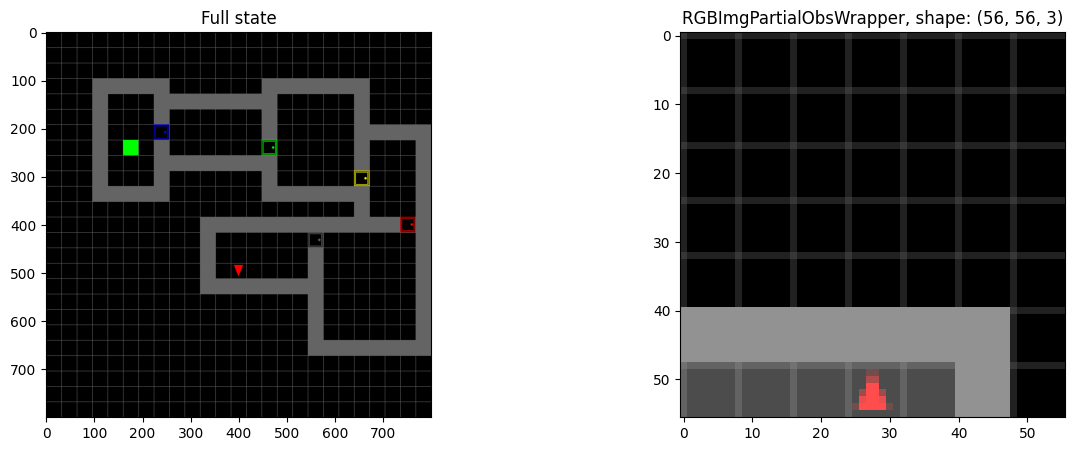

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Initializing the smaller environments


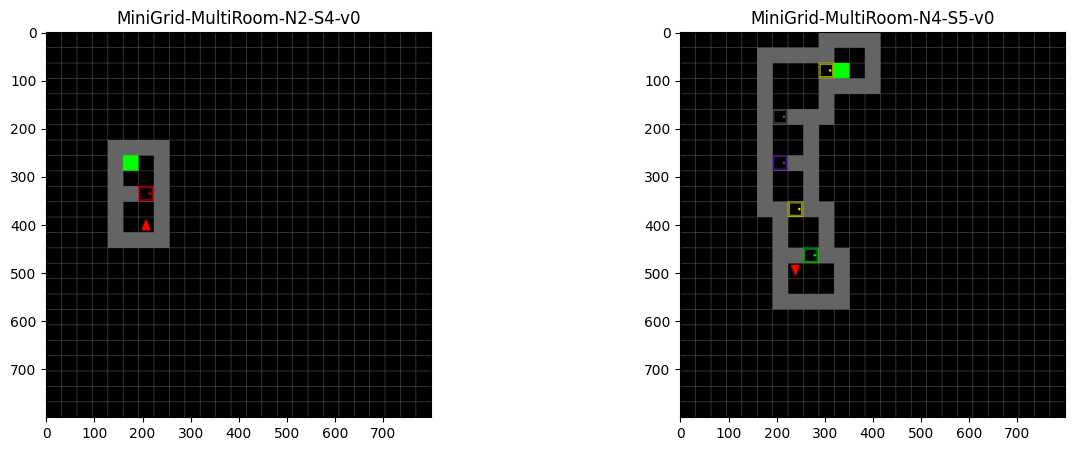

In [45]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example


In [46]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
# video_filename = '/content/vid_partial.mp4'
video_filename = "C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project/videos/vid.mp4"
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (56, 56) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


done reward= 0 num_of_steps= 120


# Your Code here ...


In [268]:
importlib.reload(display_functions)
from env_functions import create_multiroom_env, get_action_meaning
from display_functions import show_full_frame_rgb, show_partial_greyscale

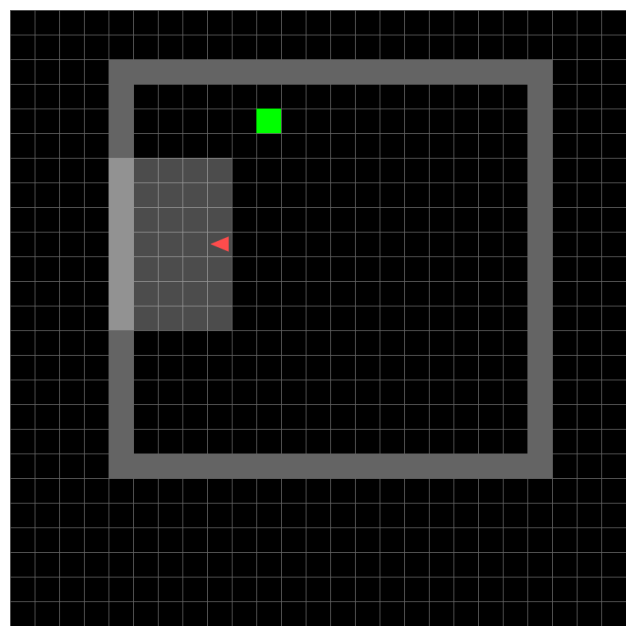

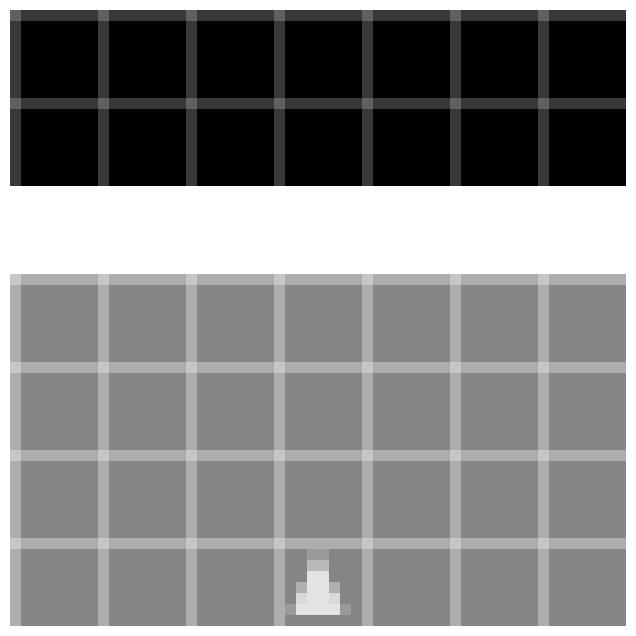

In [210]:
env, obs = create_multiroom_env(1, 50)
show_full_frame_rgb(env, obs)
img = show_partial_greyscale(env, obs)



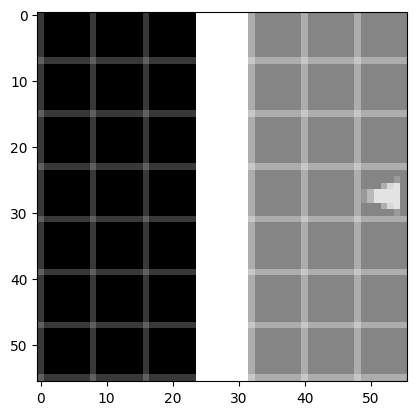

In [163]:
img
img_rotated = np.rot90(img, k=1)  # Rotate 90° clockwise
img_rotated
plt.imshow(img_rotated, cmap="gray")

--------------------------------------------------
Step 0
Action taken: 5 (Toggle)


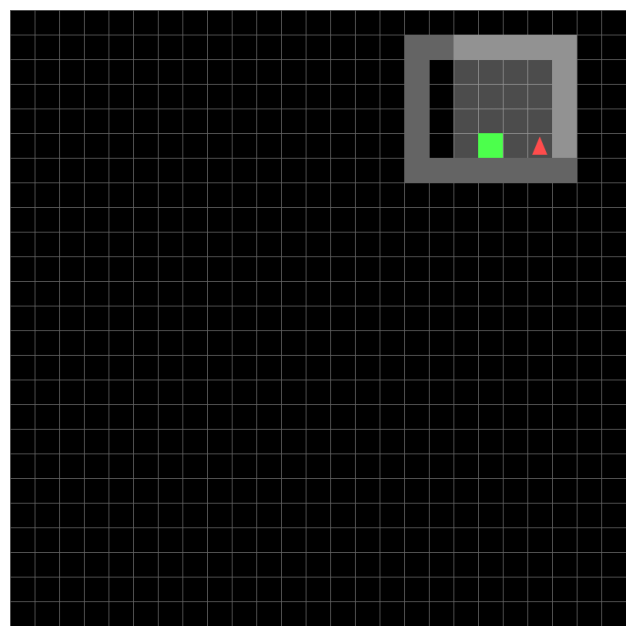

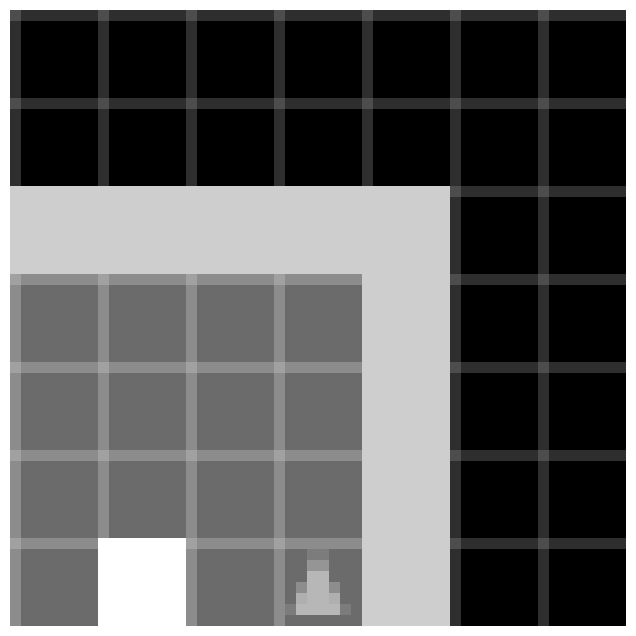

--------------------------------------------------
Step 1
Action taken: 5 (Toggle)


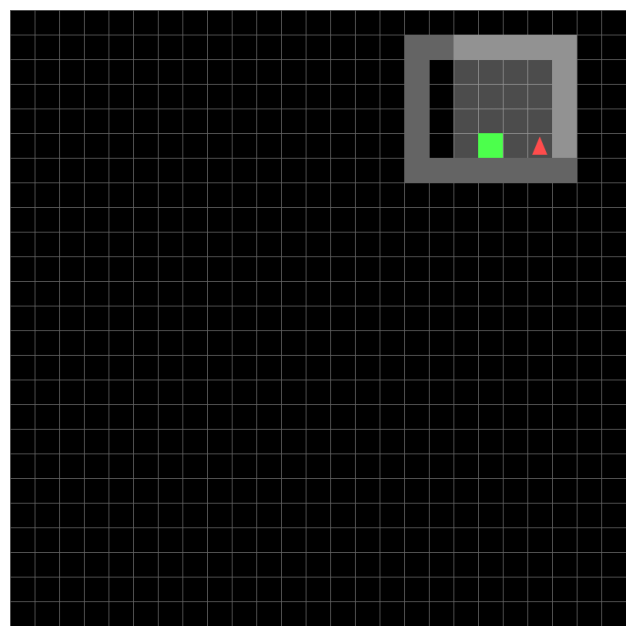

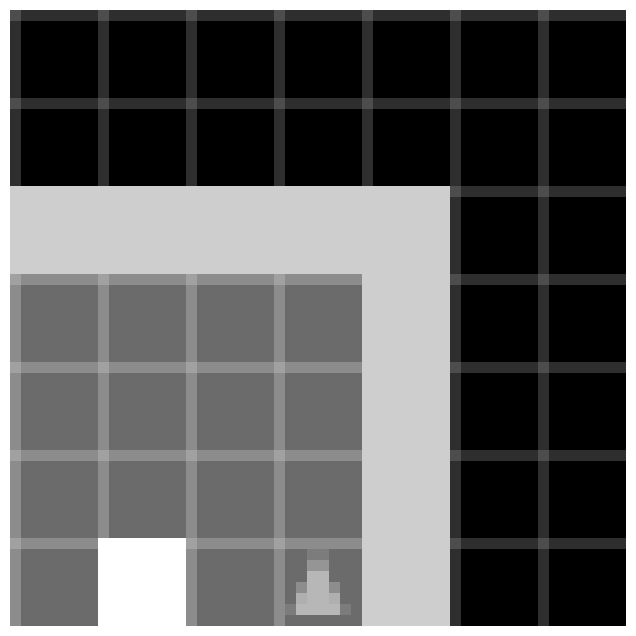

--------------------------------------------------
Step 2
Action taken: 2 (Move Forward)


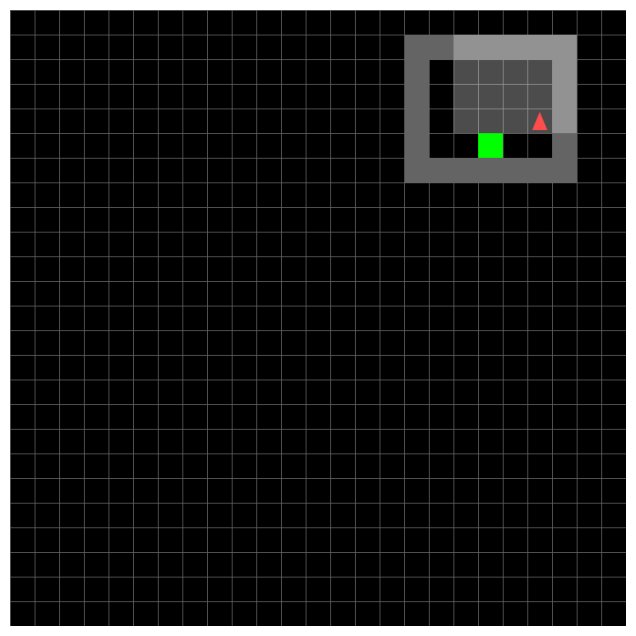

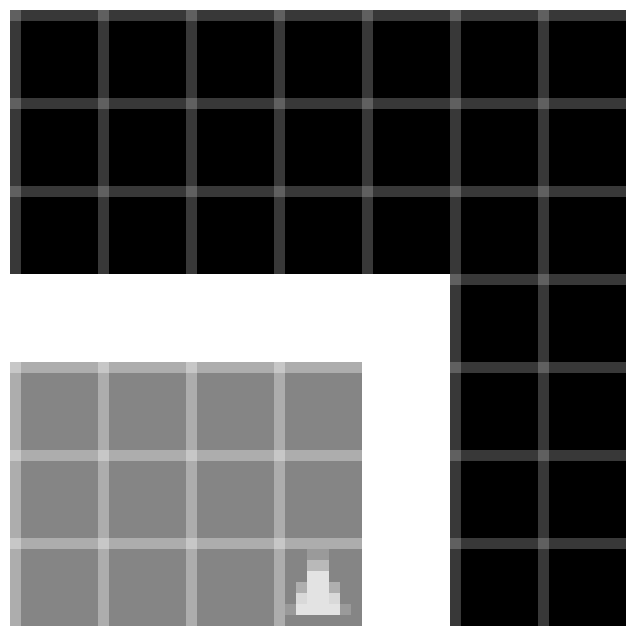

In [208]:
def show_N_steps(env, N, policy=None):
    """
    Runs N steps in the environment, rendering each step.

    Parameters:
        env: The environment instance.
        N (int): Number of steps to execute.
        policy (function): Function that takes obs and returns an action. Defaults to random.
    """
    if policy is None:
        policy = lambda obs: random.choice([0,1,2,5])  # Default to random actions

    obs, _ = env.reset()  # Ensure the environment starts correctly

    for i in range(N):
        print("--------------------------------------------------")
        print(f"Step {i}")

        action = policy(obs)  # Get action from policy
        print(f"Action taken: {action} ({get_action_meaning(action)})")
        obs, reward, done, truncated, info = env.step(action)

        show_full_frame_rgb(env, obs)
        show_partial_greyscale(env, obs)



        if done or truncated:  # Reset if the episode ends
            print("Environment reset!")
            obs, _ = env.reset()
env
# verification
show_N_steps(env, 3)


Environments like MiniGrid MultiRoom require the agent to understand spatial dependencies and remember past observations to make optimal decisions. However, standard observations only provide a single frame, making it difficult for the agent to infer motion, detect doors opening, or track past locations. In order to deal with this, especially to encourage the agent to learn the process of open door and moving to the next room, we will implement FrameStackPreprocess. In addition, this class will convert the observation to greyscale becasue the RGB channels doesn't contribute to the learning process and do downsampling to better efficency and generalization (we don't need the fine details of the environment).


In [254]:

class FrameStackPreprocess:
    """
    A wrapper for preprocessing and stacking consecutive frames into different channels.
    - Converts RGB frames to grayscale.
    - Normalizes pixel values.
    - Optionally downsamples to a target size.
    - Stacks the last N frames to capture temporal information.

    Parameters:
        num_frames (int): Number of frames to stack.
        img_size (tuple): Original (Height, Width) of frames.
        downsample_size (tuple): Target (Height, Width) after downsampling.
    """

    def __init__(self, num_frames=3, img_size=(56, 56), downsample_size=(14, 14)):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)  # Store last N frames
        self.img_size = img_size  # Ensure all frames have the same shape
        self.downsample_size = downsample_size  # Target downsampling resolution

    def _convert_to_grayscale(self, frame):
        """Converts an RGB frame to grayscale and normalizes it."""
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        frame_gray = frame_gray.astype(np.float32) / 255.0  # Normalize pixel values
        return frame_gray  # Shape: (H, W)

    def _downsample(self, frame):
        """Resizes the frame to the target downsampling size."""
        return cv2.resize(frame, self.downsample_size, interpolation=cv2.INTER_AREA)

    def preprocess(self, frame):
        """Applies grayscale conversion and downsampling."""
        gray_frame = self._convert_to_grayscale(frame)
        return self._downsample(gray_frame)

    def reset(self, first_frame):
        """Initialize the frame stack with copies of the first preprocessed frame."""
        processed_frame = self.preprocess(first_frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)

    def update(self, new_frame):
        """Add a new frame to the stack and remove the oldest."""
        processed_frame = self.preprocess(new_frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)
    
    def get_stack(self):
      return torch.tensor(self.frames)


env, obs = create_multiroom_env(1, 50)
frame_stack=FrameStackPreprocess()
frame_stack.reset(obs)
frame_stack.get_stack()



tensor([[[0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324,
          0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324],
         [0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000,
          0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000],
         [0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324,
          0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324],
         [0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000,
          0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000],
         [0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324,
          0.0620, 0.0324, 0.0620, 0.0324, 0.0620, 0.0324],
         [0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000,
          0.0324, 0.0000, 0.0324, 0.0000, 0.0324, 0.0000],
         [0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725,
          0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725],
         [0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5

In [241]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

To make sure that this fundemental class has no bug and doesn't miss crucial information for learning, we will explicitly check how the stack looks in every state in this simple environment when acting |allways forward" with 1 big room with the reward in the other side.


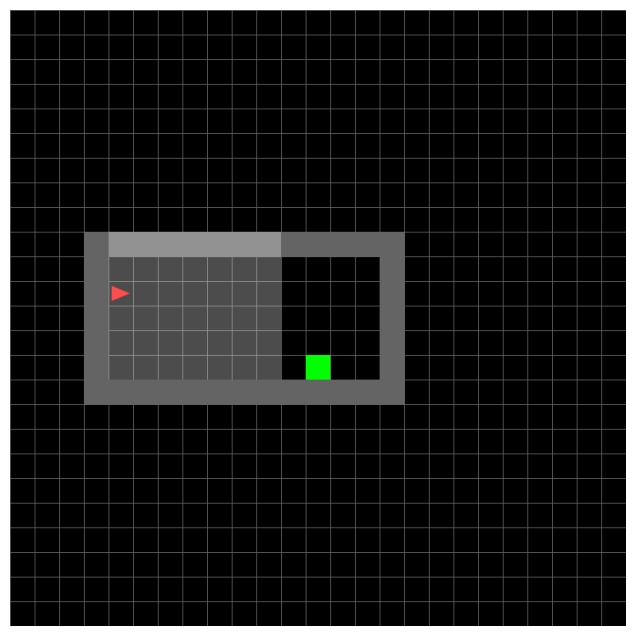

In [214]:
env, obs = create_multiroom_env(1, 50, seed=333)
show_full_frame_rgb(env, obs)

Let's have a look on the stack in the 7 first step:


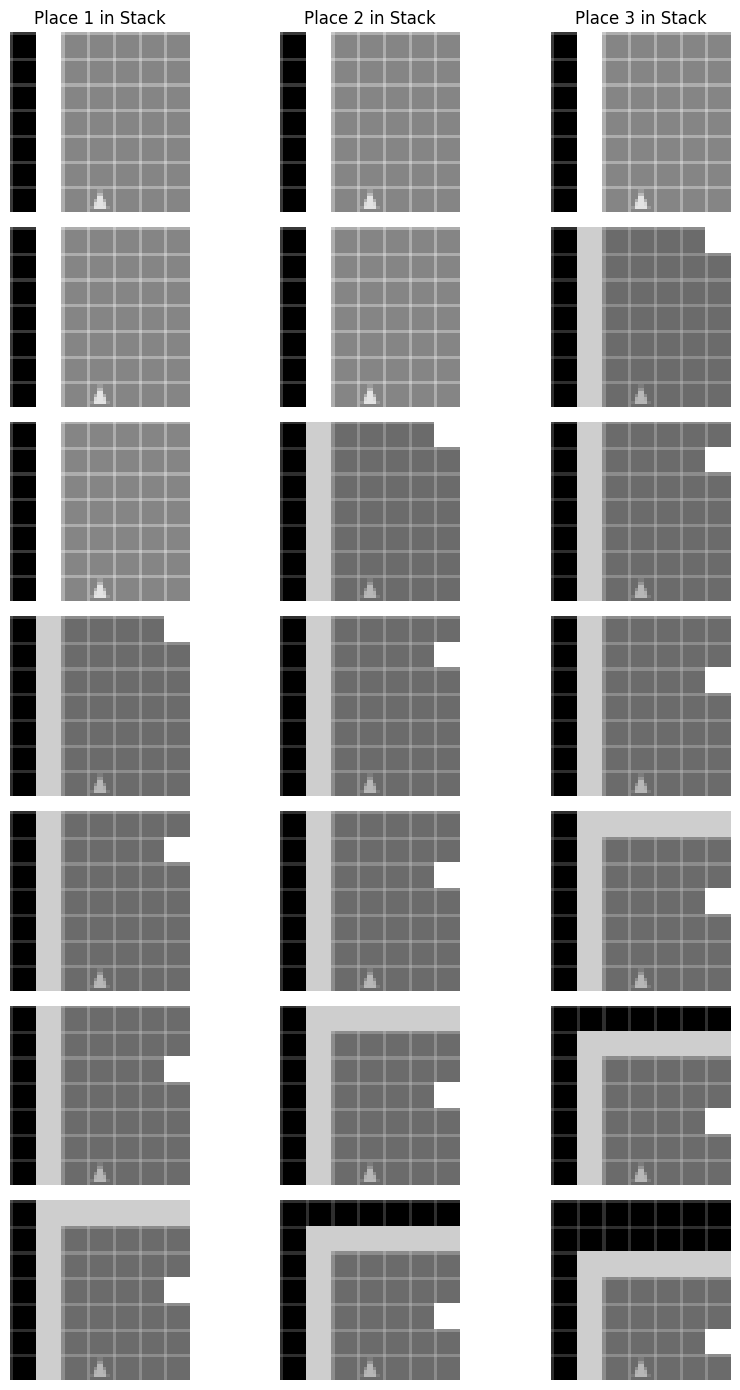

In [215]:
frame_stack = FrameStackPreprocess()
frame_stack.reset(obs)
frame_stack.get_stack().shape

action = 2 # Always move forward

import matplotlib.pyplot as plt

def visualize_frame_stack(env, preprocessor, policy, N=7):
    """
    Runs N iterations, updates FrameStackPreprocess, and directly plots stack positions.

    Parameters:
        env: The MiniGrid environment (already initialized).
        preprocessor: Instance of FrameStackPreprocess.
        policy: Function that returns the action to take.
        N: Number of iterations.

    Returns:
        None (displays plots).
    """
    fig, axes = plt.subplots(N, 3, figsize=(9, 2 * N))  # N rows, 3 columns

    for i in range(N):
        action = policy(env)  # Get action from policy
        obs, _, _, _, _ = env.step(action)  # Step in environment
        stacked_frames = preprocessor.update(obs)  # Update the stack

        for j in range(3):  # 3 stacked frames
            axes[i, j].imshow(stacked_frames[j], cmap="gray")
            axes[i, j].axis("off")
            if i == 0:
                axes[i, j].set_title(f"Place {j+1} in Stack")

    plt.tight_layout()
    plt.show()


visualize_frame_stack(env, frame_stack, lambda env: 2)

As we can see, the stack work well, the transformation of the image still allows to distinct between the tiles of wall, open tile, doors and goal.


## Implementing DQN


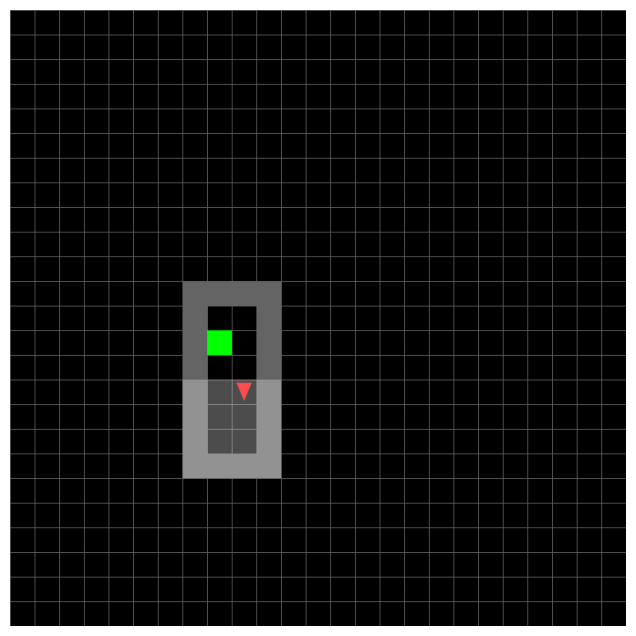

In [226]:
env, obs = create_multiroom_env(1, 8)
show_full_frame_rgb(env, obs)

In [257]:
class DQN(nn.Module):
    def __init__(self, input_size, num_actions):
        super(DQN, self).__init__()
        c, h, w = input_size # (number of frames, downsample dim 1, downsample dim 2)

        # convolution layer
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # number of elements in convolution layer
        conv_out_size = self._get_conv_size((c, h, w))

        # fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def _get_conv_size(self, shape):
        with torch.no_grad():
          dummy_tensor  = self.conv(torch.zeros(1, *shape))
          return int(np.prod(dummy_tensor .view(-1).size()))

    def forward(self, x):
      x = self.conv(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)
      return x
    

In [297]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  # Auto removes old elements

    def push(self, state, action, reward, next_state, done):
        """Stores an experience in the replay buffer"""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Returns a random mini-batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        print("states: ", states, "state type: ", type(states))
        print("actions: ", actions, "action type: ", type(actions))
        print("rewards: ", rewards, "reward type: ", type(rewards))
        print("next_states: ", next_states, "next_state type: ", type(next_states))

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
            )

    def get_all_buffer(self):
        """Returns all the buffer current content as a list"""
        return list(self.buffer)

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNAgent:
    def __init__(self,
                 input_size,
                 buffer_capacity=10000,
                 gamma=0.99,
                 lr=0.001,
                 epsilon=1.0,
                 epsilon_decay=0.995,
                 epsilon_min=0.05,
                 target_update_freq=1000,
                 device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_space = [0,1,2,5]
        self.num_actions= len(self.action_space)
        self.online_dqn = DQN(input_size, self.num_actions).to(self.device)  # main network
        self.target_dqn = DQN(input_size, self.num_actions).to(self.device)  # target network
        self.target_dqn.load_state_dict(self.online_dqn.state_dict())  # initialize the target as online first
        self.optimizer = optim.Adam(self.online_dqn.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # initial exploration rate
        self.epsilon_decay = epsilon_decay  # decay rate
        self.epsilon_min = epsilon_min  # minimum exploration rate
        self.target_update_freq = target_update_freq  # target network update frequency
        self.step_counter = 0  # step counter for updating target network

    def select_action(self, stack_frame, type='dqn'):
      """Selects an action using ε-greedy strategy (DQN or DDQN)"""
      if np.random.rand() < self.epsilon:
          return random.choice(self.action_space)  # Random action (exploration)

      self.step_counter += 1

      stack_frame = torch.tensor(stack_frame, dtype=torch.float32).unsqueeze(0).to(self.device)   # Add batch dimension

      with torch.no_grad():
          if type == 'dqn':
              q_values = self.online_dqn(stack_frame)  # Standard DQN: Q-values from the main network
          elif type == 'ddqn':
              q_values_main = self.online_dqn(stack_frame)  # Q-values from the main network
              best_action = torch.argmax(q_values_main, dim=1).item()  # Select best action
              q_values = self.target_dqn(stack_frame)  # Get Q-values from the target network
              return best_action if q_values.dim() == 1 else q_values[0, best_action].item()  # DDQN action selection

      return torch.argmax(q_values, dim=1).item()  # DQN action selection



    def update(self, batch_size=32):
      print("--------------------------------")
      print("start update!")
      print(len(self.replay_buffer))
      if len(self.replay_buffer) < batch_size:
        print(f"[DEBUG] Skipping update: Replay buffer has {len(self.replay_buffer)} samples, needs {batch_size}.")
        return  (None, None, None)



      # 1. sample form replay
      states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
      print("sample from replay buffer done")
      # 2. verify tensors in the correct device
      states      = torch.tensor(states, dtype=torch.float32, device=self.device)
      actions     = torch.tensor(actions, dtype=torch.long, device=self.device)
      rewards     = torch.tensor(rewards, dtype=torch.float32, device=self.device)
      next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
      dones       = torch.tensor(dones, dtype=torch.float32, device=self.device)
      print("variables converstion done done")

      # 3. get current A-value from online current network
      q_values = self.online_dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-values for the chosen actions
      print("q_values: ", q_values)

      # 4. compute target Q-values with online network by Bellman equation
      with torch.no_grad():
          print("computing q value")
          next_q_values = self.target_dqn(next_states).max(1)[0]
          print(next_q_values)
          target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

      # 5. compute loss and optimize by gradient descent the online network
      # loss = nn.MSELoss()(q_values, target_q_values)
      loss = F.smooth_l1_loss(q_values, target_q_values)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      gradient_norm = torch.norm(torch.cat([p.grad.view(-1) for p in self.online_dqn.parameters() if p.grad is not None])).item()


      # 6. epsilon (exploration) decay
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

      # 7. periodically update the target network
      if self.step_counter % self.target_update_freq == 0 and self.step_counter != 0:
          self.target_dqn.load_state_dict(self.online_dqn.state_dict())
      print("update done")
      return loss.item(), q_values.mean().item(), gradient_norm




In [ ]:
dqn_agent = DQNAgent(input_size=(3,7,7), buffer_capacity=64)
fram_stack = FrameStackPreprocess(num_frames=3, img_size=(56, 56), downsample_size=(14, 14))
video_filename = Path.joinpath(WORK_DIR, "videos/vid.mp4")
truncated = False
obs, _ = env.reset()
fram_stack.reset(obs)
done = False
total_reward = 0
step = 0
action = dqn_agent.select_action(fram_stack)
loss, q_value, grad = dqn_agent.update()
obs, reward, done, truncated  , _ = env.step(action)



      print(truncated)
      total_reward += reward

      next_obs = fram_stack.update(obs) 

# Evaluation
with imageio.get_writer(video_filename, fps=16) as video:
  
  fram_stack.reset(obs)
  done = False
  total_reward = 0
  step = 0
  while not (done or truncated):
      action = dqn_agent.select_action(fram_stack)
      loss, q_value, grad = dqn_agent.update()

In [ ]:
import importlib
importlib.reload(env_functions)
import env_functions

env, obs = create_multiroom_env(num_rooms=1,max_room_size= 8, max_steps=10000)
env.unwrapped.max_steps = 40

dqn_agent = DQNAgent(input_size=(3,7,7), buffer_capacity=64)
fram_stack = FrameStackPreprocess(num_frames=3, img_size=(56, 56), downsample_size=(14, 14))
video_filename = Path.joinpath(WORK_DIR, "videos/vid.mp4")
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=16) as video:
  obs, _ = env.reset()
  fram_stack.reset(obs)
  done = False
  total_reward = 0
  step = 0
  while not (done or truncated):
      action = dqn_agent.select_action(fram_stack)
      loss, q_value, grad = dqn_agent.update()

      obs, reward, done, truncated  , _ = env.step(action)
      print(truncated)
      total_reward += reward

      next_obs = fram_stack.update(obs) 
      video.append_data(env.render())

      dqn_agent.replay_buffer.push(obs, action, reward, next_obs, done)
      step += 1

      if done or truncated:
          print("Episode finished!", "Total Reward:", total_reward, "Steps:", step)
          break
embed_mp4(video_filename)

--------------------------------
start update!
0
[DEBUG] Skipping update: Replay buffer has 0 samples, needs 32.
False
--------------------------------
start update!
1
[DEBUG] Skipping update: Replay buffer has 1 samples, needs 32.
False
--------------------------------
start update!
2
[DEBUG] Skipping update: Replay buffer has 2 samples, needs 32.
False
--------------------------------
start update!
3
[DEBUG] Skipping update: Replay buffer has 3 samples, needs 32.
False
--------------------------------
start update!
4
[DEBUG] Skipping update: Replay buffer has 4 samples, needs 32.
False
--------------------------------
start update!
5
[DEBUG] Skipping update: Replay buffer has 5 samples, needs 32.
False
--------------------------------
start update!
6
[DEBUG] Skipping update: Replay buffer has 6 samples, needs 32.
False
--------------------------------
start update!
7
[DEBUG] Skipping update: Replay buffer has 7 samples, needs 32.
False
--------------------------------
start update!
8

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22776\976208212.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states      = torch.tensor(states, dtype=torch.float32, device=self.device)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22776\976208212.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions     = torch.tensor(actions, dtype=torch.long, device=self.device)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22776\976208212.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards     = torch.tensor(rewards, dtype=torch.float32, d

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 56, 56, 3] to have 3 channels, but got 56 channels instead

: 

In [290]:
env, obs = create_multiroom_env(num_rooms=1,max_room_size= 8)

env.unwrapped.max_steps=100
print(env.unwrapped.max_steps)

100


In [277]:
from typing import Tuple, Optional, Dict, Union
from gymnasium import Env
from minigrid.envs import MultiRoomEnv
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper
import numpy as np

def create_multiroom_env(
    num_rooms: int = 2,
    max_room_size: int = 5,
    render_mode: str = "rgb_array",
    seed: Optional[int] = None,
    max_steps: Optional[int] = None  ) -> Tuple[Env, np.ndarray]:
    """
    Create a wrapped MiniGrid MultiRoom environment.

    Parameters:
        num_rooms (int): Number of rooms in the environment.
        max_room_size (int): Maximum size of each room.
        render_mode (str): How to render the environment (default "rgb_array").
        seed (int, optional): Seed for environment randomness.

    Returns:
        Tuple[Env, np.ndarray]: A tuple containing:
            - env: The wrapped Gymnasium environment
            - obs: Initial observation from the environment
    
    Raises:
        ValueError: If num_rooms or max_room_size are less than 1
    """
    # Input validation
    if num_rooms < 1:
        raise ValueError("num_rooms must be at least 1")
    if max_room_size < 1:
        raise ValueError("max_room_size must be at least 1")

    # Default truncation limit if not specified
    if max_steps is None:
        max_steps = 20 * num_rooms**2  # Default truncation rule

    env = MultiRoomEnv(
        minNumRooms=num_rooms, 
        maxNumRooms=num_rooms, 
        maxRoomSize=max_room_size, 
        render_mode=render_mode
    )

    # Apply the requested wrappers
    env = RGBImgPartialObsWrapper(env)  # Converts observations to partial RGB images
    env = ImgObsWrapper(env)  # Ensures the observation space is image-based

    # Reset environment with optional seed
    obs, _ = env.reset(seed=seed) if seed is not None else env.reset()
    return env, obs